# 03 — Graph Analysis (Structure)

## Objectif
Analyser la structure du graphe biparti CV–Job construit au Notebook 02.

On calcule et interprète :
- Taille du graphe (|V|, |E|)
- Densité
- Distributions de degrés (CV et Jobs)
- Composantes connexes
- Centralités (sur projections CV–CV / Job–Job)
- Premières observations (profils polyvalents, jobs très spécialisés, etc.)

## Entrée
- `results/graph_bipartite.graphml`

## Sorties
- Figures (histogrammes degrés)
- Tableaux de métriques
- Interprétations

In [1]:
import os
import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt

from networkx.algorithms import bipartite

plt.rcParams["figure.figsize"] = (7, 4)

In [3]:
GRAPH_PATH = "results/graph_bipartite.graphml"
G = nx.read_graphml(GRAPH_PATH)

print("✅ Graph loaded:", GRAPH_PATH)
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

✅ Graph loaded: results/graph_bipartite.graphml
Nodes: 390
Edges: 1200


## 2) Séparation des ensembles bipartis (CV vs Job)

Chaque nœud a un attribut `node_type` ∈ {`cv`, `job`}.
On récupère les deux ensembles pour analyser leurs distributions séparément.

In [4]:
cv_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "cv"]
job_nodes = [n for n, d in G.nodes(data=True) if d.get("node_type") == "job"]

print("CV nodes:", len(cv_nodes))
print("Job nodes:", len(job_nodes))

CV nodes: 300
Job nodes: 90


## 3) Métriques globales

On calcule :
- Densité du graphe
- Nombre de composantes connexes
- Taille de la plus grande composante

In [5]:
density = nx.density(G)
components = list(nx.connected_components(G))
comp_sizes = sorted([len(c) for c in components], reverse=True)

print("Density:", density)
print("Connected components:", len(components))
print("Largest component size:", comp_sizes[0])
print("Top 5 component sizes:", comp_sizes[:5])

Density: 0.015819655922483685
Connected components: 1
Largest component size: 390
Top 5 component sizes: [390]


## 4) Distribution des degrés

Le degré d’un nœud = nombre de correspondances.

- Un CV avec degré élevé → profil polyvalent / compatible avec beaucoup d’offres.
- Un Job avec faible degré → poste plus spécialisé.

In [6]:
cv_deg = np.array([G.degree(n) for n in cv_nodes])
job_deg = np.array([G.degree(n) for n in job_nodes])

print("Avg degree (CV):", cv_deg.mean())
print("Median degree (CV):", np.median(cv_deg))
print("Max degree (CV):", cv_deg.max())

print("\nAvg degree (Job):", job_deg.mean())
print("Median degree (Job):", np.median(job_deg))
print("Max degree (Job):", job_deg.max())

Avg degree (CV): 4.0
Median degree (CV): 4.0
Max degree (CV): 4

Avg degree (Job): 13.333333333333334
Median degree (Job): 12.5
Max degree (Job): 29


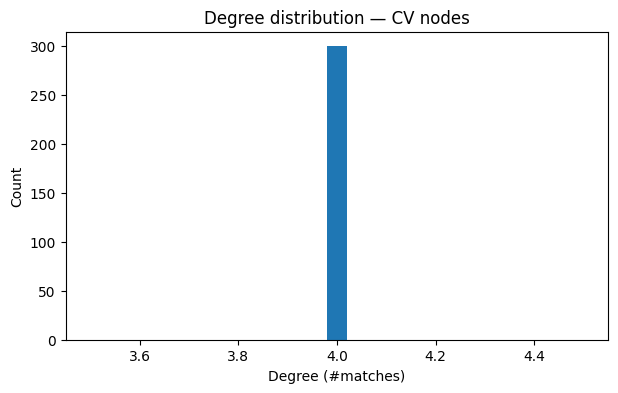

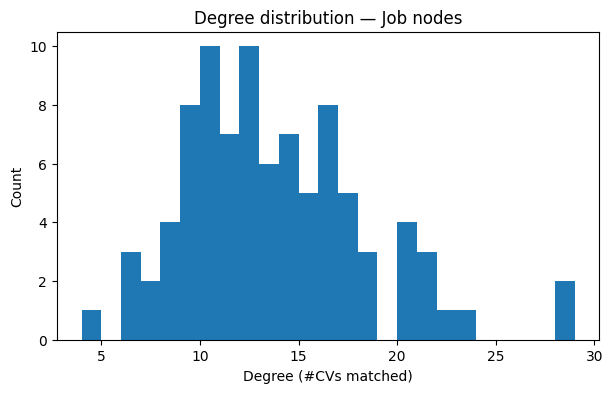

In [7]:
plt.figure()
plt.hist(cv_deg, bins=25)
plt.title("Degree distribution — CV nodes")
plt.xlabel("Degree (#matches)")
plt.ylabel("Count")
plt.show()

plt.figure()
plt.hist(job_deg, bins=25)
plt.title("Degree distribution — Job nodes")
plt.xlabel("Degree (#CVs matched)")
plt.ylabel("Count")
plt.show()

## 5) Nœuds les plus connectés (Top CV / Top Jobs)

On extrait :
- Top CV : plus de matches → profils “hub”
- Top Jobs : offres qui attirent beaucoup de CV

In [8]:
cv_top = sorted([(n, G.degree(n)) for n in cv_nodes], key=lambda x: x[1], reverse=True)[:10]
job_top = sorted([(n, G.degree(n)) for n in job_nodes], key=lambda x: x[1], reverse=True)[:10]

print("Top 10 CV (degree):")
display(pd.DataFrame(cv_top, columns=["cv_id", "degree"]))

print("Top 10 Jobs (degree):")
display(pd.DataFrame(job_top, columns=["job_id", "degree"]))

Top 10 CV (degree):


,cv_id,degree
0,CV_0000,4
1,CV_0001,4
2,CV_0002,4
3,CV_0003,4
4,CV_0004,4
5,CV_0005,4
6,CV_0006,4
7,CV_0007,4
8,CV_0008,4
9,CV_0009,4


Top 10 Jobs (degree):


,job_id,degree
0,JOB_0033,29
1,JOB_0080,28
2,JOB_0081,23
3,JOB_0050,22
4,JOB_0013,21
5,JOB_0061,21
6,JOB_0064,21
7,JOB_0009,20
8,JOB_0056,20
9,JOB_0062,20


## 6) Projections bipartites (CV–CV et Job–Job)

Pour calculer certaines centralités, on projette le graphe biparti :

- Projection CV–CV : deux CV sont connectés s’ils partagent des Jobs.
- Projection Job–Job : deux Jobs sont connectés s’ils partagent des CV.

Cela capture une similarité structurelle.

In [9]:
cv_proj = bipartite.weighted_projected_graph(G, cv_nodes)
job_proj = bipartite.weighted_projected_graph(G, job_nodes)

print("CV projection:", cv_proj.number_of_nodes(), "nodes |", cv_proj.number_of_edges(), "edges")
print("Job projection:", job_proj.number_of_nodes(), "nodes |", job_proj.number_of_edges(), "edges")


CV projection: 300 nodes | 7196 edges
Job projection: 90 nodes | 1057 edges


## 7) Centralités sur projection (exemple)

On calcule :
- **Degree centrality** (rapide)
- (Optionnel) Betweenness sur sous-graphe (car coûteux)

In [11]:
cv_deg_cent = nx.degree_centrality(cv_proj)
top_cv_cent = sorted(cv_deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
display(pd.DataFrame(top_cv_cent, columns=["cv_id", "degree_centrality"]))

,cv_id,degree_centrality
0,CV_0088,0.260870
1,CV_0290,0.257525
2,CV_0226,0.254181
3,CV_0261,0.234114
4,CV_0287,0.234114
5,CV_0081,0.230769
6,CV_0098,0.230769
7,CV_0028,0.227425
8,CV_0062,0.227425
9,CV_0114,0.227425


In [12]:
job_deg_cent = nx.degree_centrality(job_proj)
top_job_cent = sorted(job_deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
display(pd.DataFrame(top_job_cent, columns=["job_id", "degree_centrality"]))

,job_id,degree_centrality
0,JOB_0080,0.483146
1,JOB_0033,0.471910
2,JOB_0013,0.438202
3,JOB_0000,0.415730
4,JOB_0056,0.415730
5,JOB_0026,0.404494
6,JOB_0050,0.404494
7,JOB_0040,0.382022
8,JOB_0064,0.382022
9,JOB_0081,0.382022


## 8) Visualisation (échantillon) d’une projection

Les projections peuvent devenir denses, donc on visualise un échantillon.

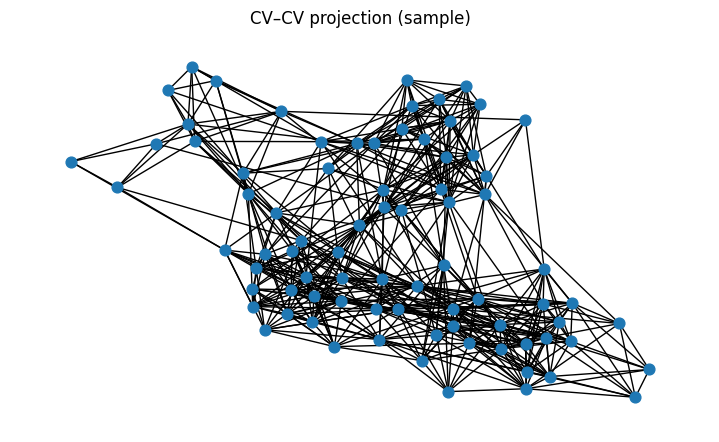

In [13]:
import random
random.seed(42)

sample_nodes = random.sample(list(cv_proj.nodes()), k=min(80, cv_proj.number_of_nodes()))
H = cv_proj.subgraph(sample_nodes).copy()

pos = nx.spring_layout(H, seed=42)

plt.figure()
nx.draw(H, pos, with_labels=False, node_size=60)
plt.title("CV–CV projection (sample)")
plt.show()

In [14]:
metrics = {
    "n_nodes": int(G.number_of_nodes()),
    "n_edges": int(G.number_of_edges()),
    "density": float(density),
    "n_components": int(len(components)),
    "largest_component": int(comp_sizes[0]),
    "avg_degree_cv": float(cv_deg.mean()),
    "avg_degree_job": float(job_deg.mean()),
    "max_degree_cv": int(cv_deg.max()),
    "max_degree_job": int(job_deg.max()),
}

os.makedirs("results", exist_ok=True)
import json
with open("results/graph_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved: results/graph_metrics.json")
metrics

✅ Saved: results/graph_metrics.json


{'n_nodes': 390,
 'n_edges': 1200,
 'density': 0.015819655922483685,
 'n_components': 1,
 'largest_component': 390,
 'avg_degree_cv': 4.0,
 'avg_degree_job': 13.333333333333334,
 'max_degree_cv': 4,
 'max_degree_job': 29}

# Conclusion

On a analysé la structure du graphe CV–Job :
- distributions de degrés (CV vs Jobs)
- densité et composantes
- projections CV–CV / Job–Job
- centralités basiques

